In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import statistics
import skimage
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import math
from math import log10

from sklearn.preprocessing import normalize, MinMaxScaler

## Radon Matrix Generation
The following code uses the scipy radon function to compute a matrix in such a way that multiplying a vectorized image with that matrix is identical to computing the radon transform

In [3]:
from skimage.transform import radon,iradon

def getRadonMatrix(theta,ny,nx):
    test = radon(np.zeros((ny,nx)) , theta=theta)
    A = np.zeros((test.size,ny*nx))
    for i in range(ny):
        for j in range(nx):
            image = np.zeros((ny,nx)) 
            image[i,j]=1
            sinogram = radon(image, theta=theta)
            A[:,j+i*nx] = np.reshape(sinogram,A.shape[0])
            
    return A
            

# Tests Radon Matrix Generation
Loads a standart test image, the 'shep logan phantom', and tests if the randon transform and the matrix multiplication do indeed coincide.
Most of this code is copied from 
https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html#sphx-glr-auto-examples-transform-plot-radon-transform-py


# MNIST loading, training, testing
A suggestion of how to start would be: Consider tutorial code for MNIST classification, e.g. from 
https://nextjournal.com/gkoehler/pytorch-mnist 
and adapt this to CT reconstruction by:
- Computing sinograms for all images by applying the radon transform to them. 
- Write a data loader in which the network input are the sinograms (possibly with noise added to them), and the labels/target data are the image. 
- Adapt the network architecture in such a way that the mapping input and output are correct, use ideas for network architectures from the lecture. For this you might want/need to create layers that compute the randon transform and its transpose, making reshaping part of the layer might make things easier for subsequent convolutional layers. 
- Replace the loss function, e.g., by a mean squared error
- Train and test your approach

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [5]:
train_set = MNIST('data', download=True, transform=transforms.ToTensor())
test_set = MNIST('data', train=False, transform=transforms.ToTensor())

In [595]:
train_set = MNIST('data', download=True, transform=transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
test_set = MNIST('data', train=False, transform= transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [6]:
# collection of sinogram and original image for training set
theta = np.linspace(0., 180., 14, endpoint=False)
A = getRadonMatrix(theta,28,28)
train=[]
for batch_idx, (data, target) in enumerate(train_set):
        # Compute sinogram with scipy
        image = data[0]
        image = image.numpy()
        if batch_idx % 10000 ==0:
            print(batch_idx)
        if batch_idx ==0:
            sinogram = radon(image, theta=theta)

        noisySino = np.reshape(A@np.reshape(image,A.shape[1]) , sinogram.shape)+0.2*np.random.randn(*sinogram.shape)
        #feature scaling the sinogram within [0,1]

#         ma = noisySino.max()
#         mi = noisySino.min()
#         for i in range (len(noisySino)):
#             for j in range (len(noisySino[0])):
#                 noisySino[i][j] = (noisySino[i][j]-mi)/(ma-mi)

        temp = (noisySino,image)
        train.append(temp)
        
print(len(train))


/home/rajan/miniconda3/envs/dl/lib/python3.9/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


0
10000
20000
30000
40000
50000
60000


In [7]:
# collection of sinogram and original image for testing set

theta = np.linspace(0., 180., 14, endpoint=False)
A = getRadonMatrix(theta,28,28)
test=[]
for batch_idx, (data, target) in enumerate(test_set):
        # Compute sinogram with scipy
        image = data[0]
        image = image.numpy()
        if(batch_idx == 0):
            sinogram = radon(image, theta=theta)
        noisySino = np.reshape(A@np.reshape(image,A.shape[1]) , sinogram.shape)+0.2*np.random.randn(*sinogram.shape)
        #feature scaling the sinogram within [0,1]
#         ma = noisySino.max()
#         mi = noisySino.min()
#         for i in range (len(noisySino)):
#             for j in range (len(noisySino[0])):
#                 noisySino[i][j] = (noisySino[i][j]-mi)/(ma-mi)
        
        temp = (noisySino,image)
        test.append(temp)
        
print(len(test))

10000


In [8]:
train_loader = DataLoader(train, batch_size=4, num_workers=4, shuffle=True)
test_loader = DataLoader(test, batch_size=4, num_workers=4, shuffle=True)

In [9]:
examples = enumerate(train_loader)
batch_idx, (data, labels) = next(examples)

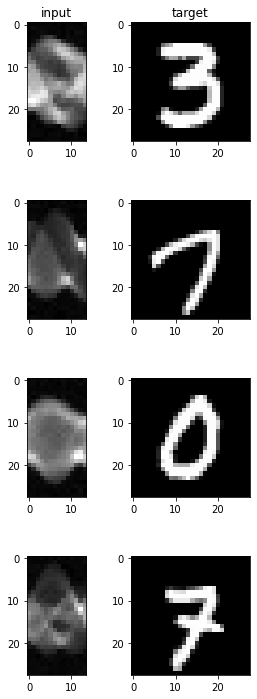

In [10]:
plt.figure(figsize=(12,12))
for i in range(len(data)):
    j = 2*i
    plt.subplot(4, 2,j+1)
    plt.imshow(data[i], cmap='gray')
    if i == 0:
        plt.title('input')
    plt.subplot(4, 2, j+2)
    plt.imshow(labels[i], cmap='gray')
    if i == 0:
        plt.title('target')
plt.subplots_adjust(wspace=-0.75, hspace=0.5)

In [11]:
examples = enumerate(test_loader)
batch_idx, (data, labels) = next(examples)

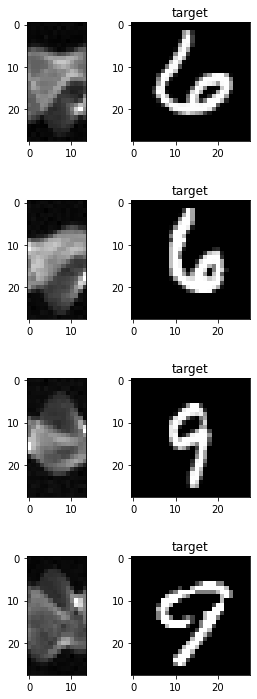

In [12]:
plt.figure(figsize=(12,12))
for i in range(len(data)):
    j = 2*i
    plt.subplot(4, 2,j+1)
    plt.imshow(data[i], cmap='gray')
    plt.subplot(4, 2, j+2)
    plt.imshow(labels[i], cmap='gray')
    plt.title('target')
plt.subplots_adjust(wspace=-0.75, hspace=0.5)

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [15]:
# Pseudo inverse computation

class Inverse():
    
    def __init__(self,batch,channel,A_inv,imageshape,reshape):
        super().__init__()
        self.batch = batch 
        self.channel = channel
        self.A_inv = A_inv
        self.imageshape = imageshape
        self.reshape = reshape
        self.imageshape = imageshape
    
    def forward(self, x,batch_size):
        y = torch.empty(batch_size,self.channel,self.imageshape[0],self.imageshape[1])
        for i in range(batch_size):
            for j in range(self.channel):
                y[i][j]=torch.clip((torch.reshape(self.A_inv@torch.reshape(
                    x[i][j], (self.reshape,1)), self.imageshape)),0,1)
                #y[i][j]=torch.reshape(self.A_inv@torch.reshape(
                    #x[i][j], (self.reshape,1)), self.imageshape)
               
        return y

In [16]:
examples = enumerate(train_loader)
batch_idx, (data, labels) = next(examples)
image = labels[0]
imageshape = image.shape
theta = np.linspace(0., 180., 14, endpoint=False)
A = getRadonMatrix(theta,28,28) #radon matrix
A = torch.tensor(A).float()
A_inv = np.linalg.pinv(A)
print(A_inv.shape)
A_inv = np.around(A_inv, decimals=4)
A_inv = torch.tensor(A_inv)
reshape = A.shape[0]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3,padding = 1)
        self.conv2 = nn.Conv2d(10, 1, kernel_size=3,padding = 1)
        self.pseudo1 = Inverse(4,1,A_inv,imageshape,reshape)
        self.conv3 = nn.Conv2d(1, 10, kernel_size=3,padding = 1)
        self.conv4 = nn.Conv2d(10, 1, kernel_size=3,padding = 1)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        y = F.relu(self.pseudo1.forward(x,len(x)))
        x = F.relu(self.conv3(y))
        x = F.relu(self.conv4(x))
        y = x
        x = torch.empty(len(x),1,28,28)
        for i in range (len(x)):
            x[i][0] = torch.clip(y[i][0],0,1)

        return x,y

(784, 392)


In [17]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [18]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [19]:
PSNR = []
SSIM = []
psnr_counter = {}
for i in range(n_epochs):
    psnr_counter[str(i+1)+'epoch']=[]
    
loss_counter = {}
for i in range(n_epochs):
    loss_counter[str(i+1)+'epoch']=[]
    
ssim_counter = {}
for i in range(n_epochs):
    ssim_counter[str(i+1)+'epoch']=[]
    


In [20]:
optimizer.zero_grad()
l = nn.MSELoss()

In [21]:

torch.autograd.set_detect_anomaly(True)
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.view(4,1,28,14)
        target = target.view(4,1,28,28)
        data = data.float()
        target = target.float()
        output1,output2 = network(data)
        loss = l(output1,target)
        loss.backward()
        optimizer.step()
       

        with torch.no_grad():
            for i in range(4):
                temp = ssim(target[i][0].numpy(),output1[i][0].numpy())
                SSIM.append(temp)
                temp = peak_signal_noise_ratio(target[i][0].numpy(),output1[i][0].numpy())
                PSNR.append(temp)
             

        if batch_idx % 64 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*4) + ((epoch-1)*len(train_loader.dataset)))
    print(loss)


In [22]:
def test():
    network.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.view(4,1,28,14)
            target = target.view(4,1,28,28)
            data = data.float()
            target = target.float()
            output1,output2 = network(data)
            test_loss += l(output1,target).item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print('testloss is:',test_loss)

In [23]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

testloss is: 0.11377903299927712
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.096861
Train Epoch: 1 [256/60000 (0%)]	Loss: 0.077947
Train Epoch: 1 [512/60000 (1%)]	Loss: 0.070809
Train Epoch: 1 [768/60000 (1%)]	Loss: 0.093478
Train Epoch: 1 [1024/60000 (2%)]	Loss: 0.084652
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.076761
Train Epoch: 1 [1536/60000 (3%)]	Loss: 0.103345
Train Epoch: 1 [1792/60000 (3%)]	Loss: 0.078706
Train Epoch: 1 [2048/60000 (3%)]	Loss: 0.060438
Train Epoch: 1 [2304/60000 (4%)]	Loss: 0.032066
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.016007
Train Epoch: 1 [2816/60000 (5%)]	Loss: 0.014777
Train Epoch: 1 [3072/60000 (5%)]	Loss: 0.009892
Train Epoch: 1 [3328/60000 (6%)]	Loss: 0.012063
Train Epoch: 1 [3584/60000 (6%)]	Loss: 0.010491
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.008548
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.009571
Train Epoch: 1 [4352/60000 (7%)]	Loss: 0.008226
Train Epoch: 1 [4608/60000 (8%)]	Loss: 0.007063
Train Epoch: 1 [4864/60000 (8%)]	Loss: 0.005913
Train Epoch: 

Train Epoch: 1 [42240/60000 (70%)]	Loss: 0.002949
Train Epoch: 1 [42496/60000 (71%)]	Loss: 0.002513
Train Epoch: 1 [42752/60000 (71%)]	Loss: 0.003260
Train Epoch: 1 [43008/60000 (72%)]	Loss: 0.002720
Train Epoch: 1 [43264/60000 (72%)]	Loss: 0.004604
Train Epoch: 1 [43520/60000 (73%)]	Loss: 0.002742
Train Epoch: 1 [43776/60000 (73%)]	Loss: 0.003181
Train Epoch: 1 [44032/60000 (73%)]	Loss: 0.001932
Train Epoch: 1 [44288/60000 (74%)]	Loss: 0.002436
Train Epoch: 1 [44544/60000 (74%)]	Loss: 0.002366
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.003007
Train Epoch: 1 [45056/60000 (75%)]	Loss: 0.002136
Train Epoch: 1 [45312/60000 (76%)]	Loss: 0.002210
Train Epoch: 1 [45568/60000 (76%)]	Loss: 0.004244
Train Epoch: 1 [45824/60000 (76%)]	Loss: 0.002415
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.002303
Train Epoch: 1 [46336/60000 (77%)]	Loss: 0.002699
Train Epoch: 1 [46592/60000 (78%)]	Loss: 0.002527
Train Epoch: 1 [46848/60000 (78%)]	Loss: 0.002719
Train Epoch: 1 [47104/60000 (79%)]	Loss: 0.001896


Train Epoch: 2 [24064/60000 (40%)]	Loss: 0.002149
Train Epoch: 2 [24320/60000 (41%)]	Loss: 0.001924
Train Epoch: 2 [24576/60000 (41%)]	Loss: 0.002546
Train Epoch: 2 [24832/60000 (41%)]	Loss: 0.002817
Train Epoch: 2 [25088/60000 (42%)]	Loss: 0.003181
Train Epoch: 2 [25344/60000 (42%)]	Loss: 0.004244
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.002798
Train Epoch: 2 [25856/60000 (43%)]	Loss: 0.002641
Train Epoch: 2 [26112/60000 (44%)]	Loss: 0.001902
Train Epoch: 2 [26368/60000 (44%)]	Loss: 0.002639
Train Epoch: 2 [26624/60000 (44%)]	Loss: 0.002729
Train Epoch: 2 [26880/60000 (45%)]	Loss: 0.002309
Train Epoch: 2 [27136/60000 (45%)]	Loss: 0.001914
Train Epoch: 2 [27392/60000 (46%)]	Loss: 0.002513
Train Epoch: 2 [27648/60000 (46%)]	Loss: 0.001976
Train Epoch: 2 [27904/60000 (47%)]	Loss: 0.002365
Train Epoch: 2 [28160/60000 (47%)]	Loss: 0.003969
Train Epoch: 2 [28416/60000 (47%)]	Loss: 0.002621
Train Epoch: 2 [28672/60000 (48%)]	Loss: 0.001834
Train Epoch: 2 [28928/60000 (48%)]	Loss: 0.003982


Train Epoch: 3 [5888/60000 (10%)]	Loss: 0.003157
Train Epoch: 3 [6144/60000 (10%)]	Loss: 0.002411
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.002547
Train Epoch: 3 [6656/60000 (11%)]	Loss: 0.002396
Train Epoch: 3 [6912/60000 (12%)]	Loss: 0.002447
Train Epoch: 3 [7168/60000 (12%)]	Loss: 0.002025
Train Epoch: 3 [7424/60000 (12%)]	Loss: 0.002919
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.002180
Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.002151
Train Epoch: 3 [8192/60000 (14%)]	Loss: 0.001927
Train Epoch: 3 [8448/60000 (14%)]	Loss: 0.002880
Train Epoch: 3 [8704/60000 (15%)]	Loss: 0.002528
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.002093
Train Epoch: 3 [9216/60000 (15%)]	Loss: 0.001707
Train Epoch: 3 [9472/60000 (16%)]	Loss: 0.003040
Train Epoch: 3 [9728/60000 (16%)]	Loss: 0.002368
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.002409
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.003009
Train Epoch: 3 [10496/60000 (17%)]	Loss: 0.001779
Train Epoch: 3 [10752/60000 (18%)]	Loss: 0.001720
Train Epoch: 3 [1

Train Epoch: 3 [48128/60000 (80%)]	Loss: 0.001877
Train Epoch: 3 [48384/60000 (81%)]	Loss: 0.002423
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.004917
Train Epoch: 3 [48896/60000 (81%)]	Loss: 0.002669
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.003563
Train Epoch: 3 [49408/60000 (82%)]	Loss: 0.001949
Train Epoch: 3 [49664/60000 (83%)]	Loss: 0.001773
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.003002
Train Epoch: 3 [50176/60000 (84%)]	Loss: 0.002734
Train Epoch: 3 [50432/60000 (84%)]	Loss: 0.002051
Train Epoch: 3 [50688/60000 (84%)]	Loss: 0.002749
Train Epoch: 3 [50944/60000 (85%)]	Loss: 0.002131
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.001410
Train Epoch: 3 [51456/60000 (86%)]	Loss: 0.001986
Train Epoch: 3 [51712/60000 (86%)]	Loss: 0.002262
Train Epoch: 3 [51968/60000 (87%)]	Loss: 0.003189
Train Epoch: 3 [52224/60000 (87%)]	Loss: 0.002862
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.001650
Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.002297
Train Epoch: 3 [52992/60000 (88%)]	Loss: 0.002311


In [24]:

dd = pd.DataFrame(PSNR)
dd = dd.describe().round(decimals = 2)
dd = dd.T
print(dd.to_latex())  

dm = pd.DataFrame(train_losses)
dm = dm.describe().round(decimals = 4)
dm = dm.T
print(dm.to_latex())  

ds = pd.DataFrame(SSIM)
ds = ds.describe().round(decimals = 2)
ds = ds.T
print(ds.to_latex())



\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &   mean &   std &   min &    25\% &    50\% &   75\% &    max \\
\midrule
0 &  180000.0 &  25.59 &  2.69 &  6.35 &  24.46 &  25.84 &  27.1 &  34.77 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &   mean &     std &     min &     25\% &     50\% &     75\% &     max \\
\midrule
0 &  705.0 &  0.004 &  0.0092 &  0.0012 &  0.0022 &  0.0027 &  0.0033 &  0.1033 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &  mean &  std &   min &   25\% &   50\% &   75\% &  max \\
\midrule
0 &  180000.0 &  0.95 &  0.1 &  0.01 &  0.96 &  0.97 &  0.98 &  1.0 \\
\bottomrule
\end{tabular}



Text(0, 0.5, 'loss')

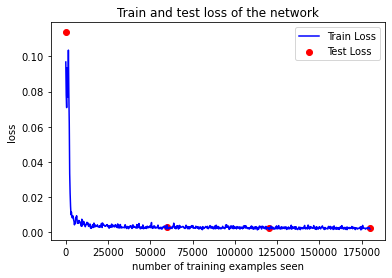

In [59]:
plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss','Test Loss'], loc='upper right')
plt.title('Train and test loss of the network')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [ ]:
#Image reconstruction by filtered back projection 

psnrf = {'filtered back projection':[]}
loss_mse={'MSE_loss':[]}
ssim_loss = {'SSIM':[]}
plt.figure(figsize=(8,6))
for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(4):
        reconstruction_fbp = np.clip(iradon(data[i].numpy(), theta=theta, filter='ramp'),0,1)
        temp = peak_signal_noise_ratio(target[i].numpy(),reconstruction_fbp)
        psnrf['filtered back projection'].append(temp)
        temp = skimage.metrics.mean_squared_error(reconstruction_fbp,target[i].numpy())
        loss_mse['MSE_loss'].append(temp)
        temp = skimage.metrics.structural_similarity(target[i].numpy(),reconstruction_fbp)
        ssim_loss['SSIM'].append(temp)




<ipython-input-28-b7fc33e85184>:7: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = np.clip(iradon(data[i].numpy(), theta=theta, filter='ramp'),0,1)
<ipython-input-28-b7fc33e85184>:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  temp = peak_signal_noise_ratio(target[i].numpy(),reconstruction_fbp)
<ipython-input-28-b7fc33e85184>:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  temp = skimage.metrics.structural_similarity(target[i].numpy(),reconstruction_fbp)


In [27]:
dy = pd.DataFrame(psnrf)
dy = dy.describe()
dy = dy.round(decimals = 2)
dy = dy.T
print(dy.to_latex()) 
do = pd.DataFrame(loss_mse)
do = do.describe()
do = do.round(decimals = 4)
do = do.T
print(do.to_latex()) 
dx = pd.DataFrame(ssim_loss)
dx = dx.describe()
dx = dx.round(decimals = 2)
dx = dx.T
print(dx.to_latex()) 


\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
filtered back projection &  60000.0 &  22.46 &  1.07 &  18.09 &  21.78 &  22.41 &  23.04 &  26.91 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &    mean &     std &    min &    25\% &     50\% &     75\% &     max \\
\midrule
MSE\_loss &  60000.0 &  0.0058 &  0.0014 &  0.002 &  0.005 &  0.0057 &  0.0066 &  0.0155 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &  mean &   std &   min &   25\% &   50\% &   75\% &   max \\
\midrule
SSIM &  60000.0 &  0.78 &  0.07 &  0.55 &  0.72 &  0.78 &  0.83 &  0.96 \\
\bottomrule
\end{tabular}



torch.Size([1, 1, 28, 28])


<ipython-input-77-2fa8ed1963ac>:15: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = np.clip(iradon(data.numpy(), theta=theta, filter='ramp'),0,1)
<ipython-input-77-2fa8ed1963ac>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


Text(0.5, 1.0, 'FBP \n PSNR =19.7')

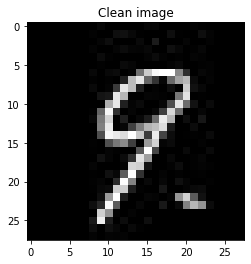

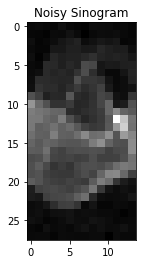

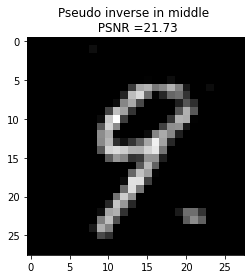

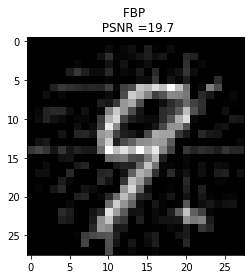

In [77]:
#single test image 

def normal(data):
    ma = data.max()
    mi = data.min()
    x = np.zeros((data.shape[0],data.shape[1]))
    for i in range (len(data)):
        for j in range (len(data[0])):
            x[i][j] = (data[i][j]-mi)/(ma-mi)
    return(x)

target = plt.imread('img_9.jpg')
target = normal(target)

data = np.reshape(A@np.reshape(target,A.shape[1]) , sinogram.shape)+0.2*np.random.randn(*sinogram.shape)
#data = normal(data)
reconstruction_fbp = np.clip(iradon(data.numpy(), theta=theta, filter='ramp'),0,1)
temp1 = peak_signal_noise_ratio(target,reconstruction_fbp).round(decimals = 2)

with torch.no_grad():
    target = torch.tensor(target)
    target = target.view(1,1,28,28)
    target = target.float()
    data = torch.tensor(data)
    data = data.view(1,1,28,14)
    data = data.float()
    print(target.shape)
    output1,output2= network(data)
    temp2 = peak_signal_noise_ratio(target[0][0].numpy(),output1[0][0].numpy()).round(decimals = 2)



plt.figure()
plt.imshow(target[0][0], cmap='gray')
plt.title('Clean image')                                    
plt.figure()
plt.imshow(data[0][0], cmap='gray')
plt.title('Noisy Sinogram')                                                                        
plt.figure()
plt.imshow(output1[0][0], cmap='gray')
plt.title('Pseudo inverse in middle \n PSNR ='+str(temp2))                                    
                                   
plt.figure()
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('FBP \n PSNR ='+str(temp1))                                    
                                    


tensor(0.0018)
   PSNR_image generated  PSNR after inverse
0             29.848294           21.794694
1             30.228211           23.212246
2             26.053280           18.049923
3             25.459161           18.453629


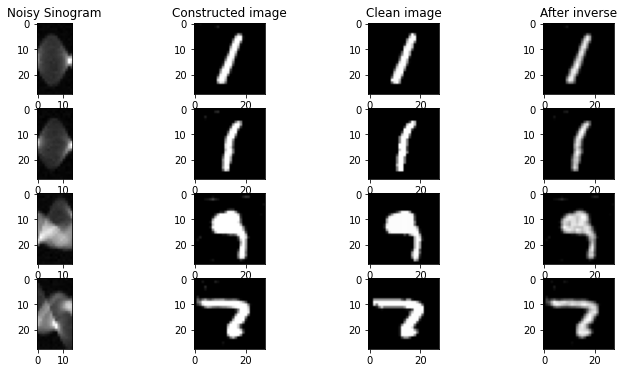

In [68]:

t = enumerate(test_loader)
batch_idx, (data, target) =next(t)
with torch.no_grad():
    optimizer.zero_grad()
    data = data.view(4,1,28,14)
    target = target.view(4,1,28,28)
    data = data.float()
    target = target.float()
    output1,output2= network(data)
    loss1 = l(output1,target)
    print(loss1)

    PSNR = []
    plt.figure(figsize=(12,6))

    for i in range(len(data)):
        #temp = [10 * log10(1 / loss1.item()),10 * log10(1 / loss1.item())]
        temp = [peak_signal_noise_ratio(target[i][0].numpy(),output1[i][0].numpy())
               ,peak_signal_noise_ratio(target[i][0].numpy(),output2[i][0].numpy())]
        PSNR.append(temp)

        j = 4*i
        plt.subplot(4, 4,j+1)
        plt.imshow(data[i][0], cmap='gray')
        if i == 0:
            plt.title('Noisy Sinogram')
        plt.subplot(4, 4, j+2)
        plt.imshow(output1[i][0], cmap='gray')
        if i == 0:
            plt.title('Constructed image')


        plt.subplot(4, 4, j+3)
        plt.imshow(target[i][0], cmap='gray')
        if i == 0:
            plt.title('Clean image')   
        plt.subplot(4, 4, j+4)
        plt.imshow(output2[i][0], cmap='gray')
        if i == 0:
            plt.title('After inverse')

df = pd.DataFrame(data=PSNR,columns=['PSNR_image generated', 'PSNR after inverse'])
print(df)
#plt.subplots_adjust(wspace=-0.5, hspace=1)